In [4]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests


#### Data Bullshit

In [5]:
Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)
Data = Data.sort_values(["gene",'average phenotype of strongest 3'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
UCSC_TSS = pd.read_csv('UCSC_TSS.txt', delimiter = '\t',header = 0)
UCSC_TSS = UCSC_TSS.drop_duplicates() 

errors = []

for gene in (Data['gene']):
        try:
                if len(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"]) > 1:
                        x = abs(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"] - Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1]).min()
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = (int(Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1] - int(x) + 1))
                else:
                        x = UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"].iloc[-1]
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = int(x) + 1 
              

        except:
            errors.append(gene)

len(errors)

Data = Data.reset_index()

In [6]:
Promoter_sequences = pd.read_csv('3kb_Promoter.sequences-2.csv', sep=',', header = 0)
Promoter_sequences = pd.merge(how = 'outer', left = Promoter_sequences, right = Data, left_on = 'Gene', right_on = 'gene')
Promoter_sequences = Promoter_sequences.dropna()

In [7]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = pd.DataFrame(cpgs)

# Only select a single value per gene, to prevent duplicates

cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')

In [8]:
df = pd.merge(how = 'outer', left = Promoter_sequences, right = cpgs, left_on = 'Gene', right_on = 'gene')
df = df.loc[df.Gene.notna()]
df = df.reset_index()

In [9]:
df = df.dropna()

In [10]:
irbs = pd.read_csv('wgEncodeHaibMethylRrbsK562HaibSitesRep1.bed', sep='\t', header = 0)
#Extract only the values with 100% Certainty of methylation 
irbs = irbs[irbs['Unnamed: 8'] == '255,0,0']

chromosome_list = np.unique(irbs.track)

18750


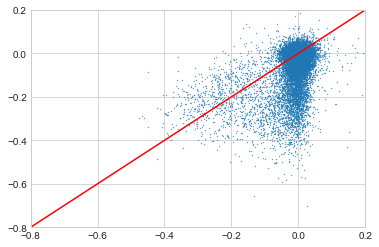

In [26]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'],s = 0.1)
         
plt.axis([-0.8,0.2,-0.8,0.2])
x = [-1,-1,1,1]
y = x
plt.plot(x,y, 'r')

print(len(df))


In [13]:
df = df[df.CRISPRoff_average < -0.2]
df = df[df.mutant_average > -0.2 ]

### 2 Kmers

In [8]:
Properties = pd.read_csv('dinucleotide_properties.csv', delimiter = ',',header = 1)
Properties

,Physicochemical properties,GG,GA,GC,GT,AG,AA,AC,AT,CG,CA,CC,CT,TG,TA,TC,TT
0,Base stacking,-0.07,-0.65,-2.46,-0.92,0.49,1.02,-0.92,0.57,-0.58,0.57,-0.07,0.49,0.57,1.60,-0.65,1.02
1,Protein induced deformability,0.36,-0.14,-0.30,-0.83,-0.89,-0.64,-0.83,-1.05,2.23,1.51,0.36,-0.89,1.51,0.42,-0.14,-0.64
2,B-DNA twist,-0.06,1.11,0.79,-0.65,-1.33,0.00,-0.65,2.09,-1.14,0.60,-0.06,-1.33,0.60,-1.06,1.11,0.00
3,Dinucleotide GC Content,1.37,0.00,1.37,0.00,0.00,-1.37,0.00,-1.37,1.37,0.00,1.37,0.00,0.00,-1.37,0.00,-1.37
4,A-philicity,-1.19,1.02,0.32,-1.36,-0.80,0.99,-1.36,-0.10,-0.27,1.19,-1.19,-0.80,1.19,0.32,1.02,0.99
5,Propeller twist,1.40,-0.27,0.47,-0.16,-0.44,-1.89,-0.16,-0.75,0.80,0.98,1.40,-0.44,0.98,0.23,-0.27,-1.89
6,Duplex stability:(freeenergy),-1.23,0.27,-1.23,0.27,0.27,0.83,0.27,1.40,-2.17,-0.11,-1.23,0.27,-0.11,1.40,0.27,0.83
7,Duplex tability(disruptenergy),1.40,-0.50,1.40,-0.88,-0.50,-0.12,-0.88,-1.39,2.04,-0.12,1.40,-0.50,-0.12,-0.63,-0.50,-0.12
8,DNA denaturation,0.67,-0.22,2.35,1.11,0.02,-0.84,1.11,-0.58,0.19,-0.92,0.67,0.02,-0.92,-1.60,-0.22,-0.84
9,Bending stiffness,2.08,-0.12,0.67,-0.12,-0.12,-0.90,-0.12,-1.37,0.67,-0.12,2.08,-0.12,-0.12,-1.37,-0.12,-0.90


In [9]:
kmer_length = 2

def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [10]:
from collections import Counter

def Count_kmer(a_table, gc_elements, kmer):

    sequence = getKmers(str(a_table), kmer)

    gc_kmers = []
    gc_counts = Counter(sequence)

    for index, element in enumerate(gc_elements):

        if element in (dict(gc_counts)):
            gc_kmers.append((dict(gc_counts)[gc_elements[index]]))
        
        else:
            gc_kmers.append(0)
            #print(element, 'not in kmers')
            
    return(sum(gc_kmers)/3000*100)

#Promoter_sequences['kmers'] = Promoter_sequences.Sequences.apply(lambda x: Count_kmer(x, ['gg','cc','gc','cg'], 2))

Sequences_GC_kmers = [Count_kmer(i, ['gc'], 2) for i in df.Sequences]

In [193]:
getKmers(df.Sequences[0],2).count('aa')/3000*100

7.3999999999999995

In [11]:
kmers_2 = np.unique(getKmers(df.Sequences[1], 2))

In [12]:
DNA_features = pd.DataFrame()
DNA_features = pd.DataFrame(index = range(len(df.Sequences)), columns = kmers_2)

for i, o in enumerate(df.Sequences[:]):
    for x in kmers_2:
        DNA_features[x][i] = Count_kmer(o, [x], 2)

In [13]:
cp = DNA_features

In [14]:
kmers_2

array(['aa', 'ac', 'ag', 'at', 'ca', 'cc', 'cg', 'ct', 'ga', 'gc', 'gg',
       'gt', 'ta', 'tc', 'tg', 'tt'], dtype='<U2')

In [173]:
cp.aa.max()

19.900000000000002

In [15]:
cp['CRISPRoff_average'] = df['CRISPRoff_average']

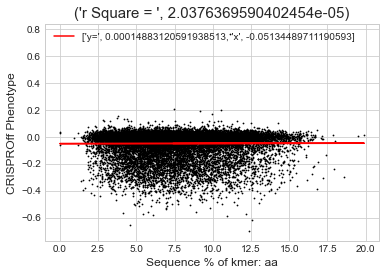

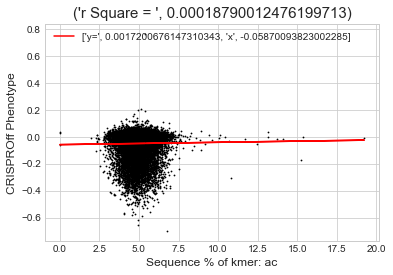

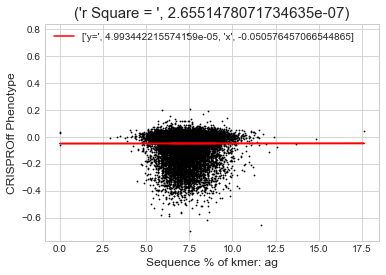

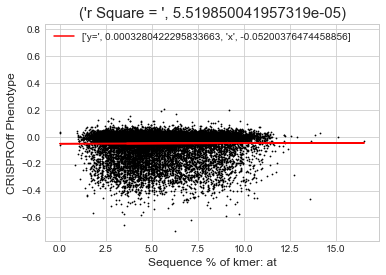

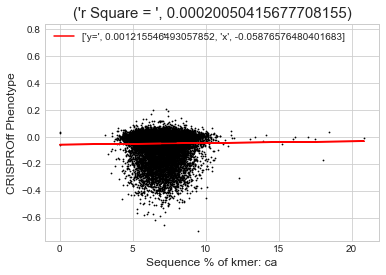

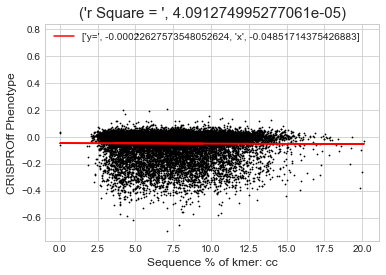

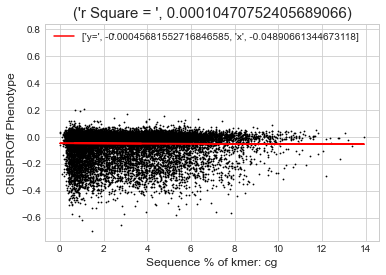

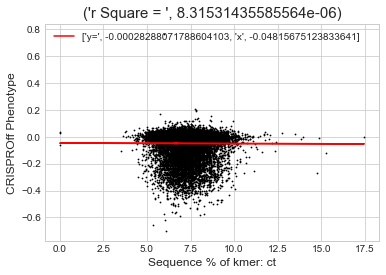

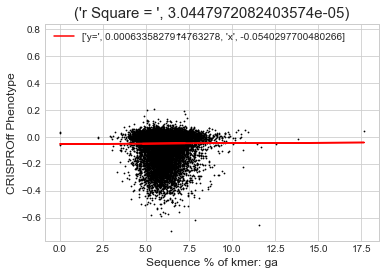

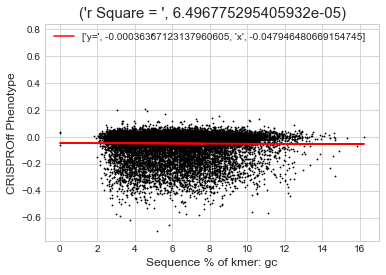

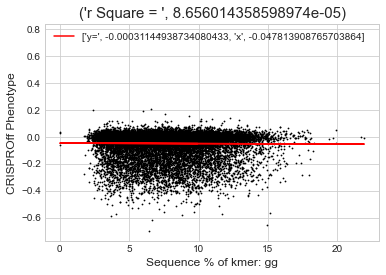

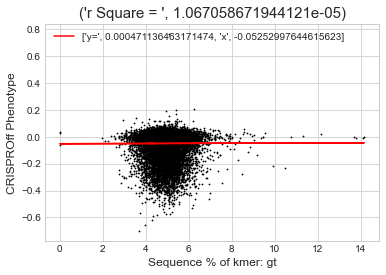

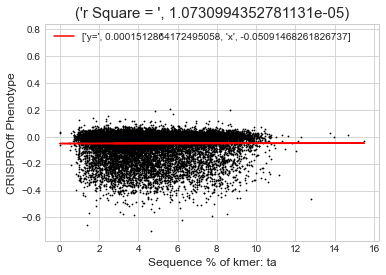

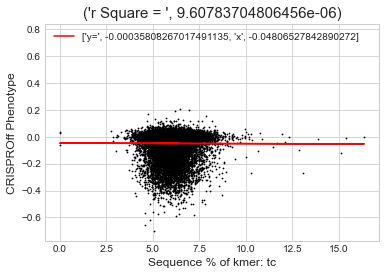

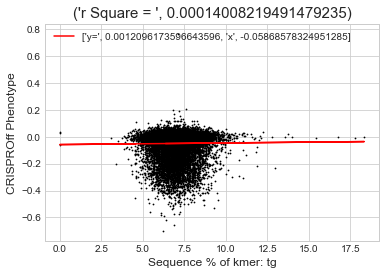

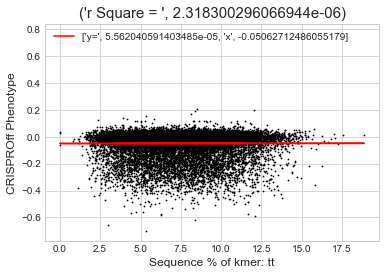

problem with CRISPRoff_average


In [84]:
from sklearn.linear_model import LinearRegression

cycles = 0
r = 0
best = 'lol'
r_sq = 0

import plotly.io as pio
import plotly.express as px
import plotly.offline as py

# fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species", size="sepal_length")
# fig

for i in cp.columns[:]:
    try:

        regression_data = cp[['CRISPRoff_average',i]].dropna()

        x =  np.array(regression_data[i].astype('float32')).reshape((-1,1))
        y =  np.array(regression_data.CRISPRoff_average)

        model = LinearRegression()
        model.fit(x,y)
        model = LinearRegression().fit(x,y)

        #Step 4: Get results

#Once you have your model fitted, you can get the results to check whether the model works satisfactorily and interpret it.
#You can obtain the coefficient of determination (𝑅²) with .score() called on model:

        r_sq = model.score(x, y)

#When you’re applying .score(), the arguments are also the predictor x and regressor y, and the return value is 𝑅².
#The attributes of model are .intercept_, which represents the coefficient, 𝑏₀ and .coef_, which represents 𝑏₁:

        m,b = np.polyfit(np.array(regression_data[i].astype('float32')),y,1)
      
        # if r_sq > r:
        r = r_sq

        # fig = px.scatter(cp, x= i , y="CRISPRoff_average")
        # fig.show()


        plt.title(('r Square = ', r_sq), size = 15)
        plt.ylabel('CRISPROff Phenotype', size = 12)
        plt.xlabel('Sequence % of kmer: '+ i, size = 12)
        plt.scatter(x=cp[i], y=cp.CRISPRoff_average, c = 'black', s = 0.6)

        plt.plot(x, m*x + b, '-r', label = ['y=', m,'x',b])
        plt.legend(loc='upper left')
        plt.show()
        # else:
        #     r_sq = r_sq

        
    except:
        #continue
        print('problem with', i )
       # print(len(x), len(y))



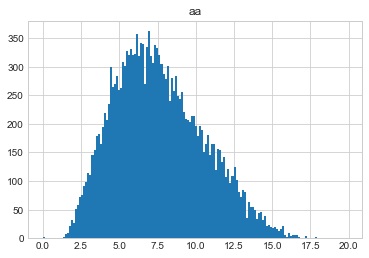

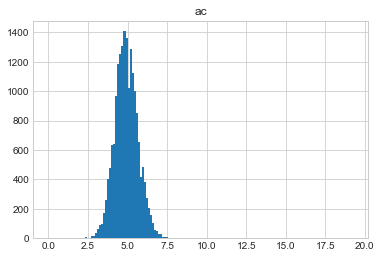

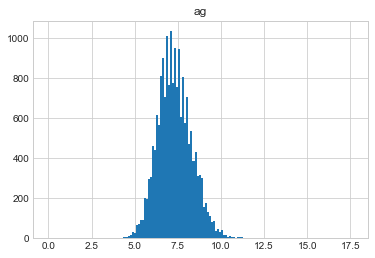

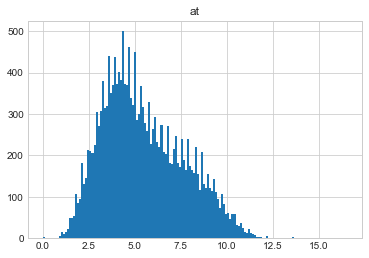

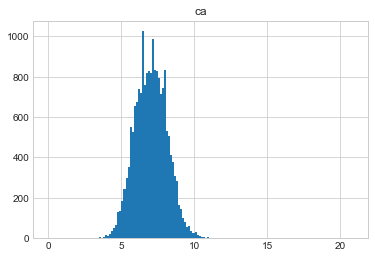

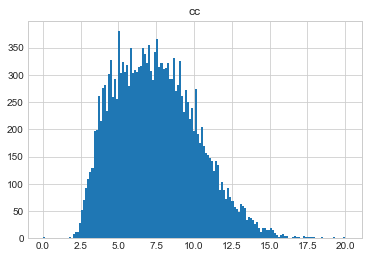

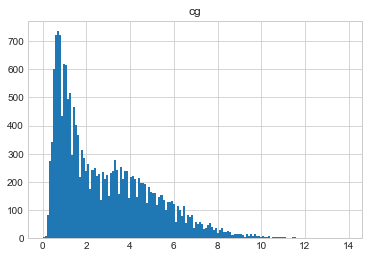

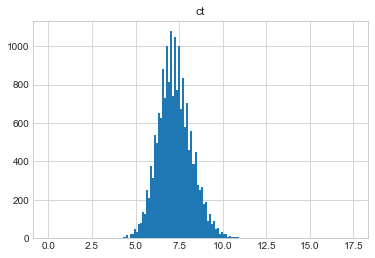

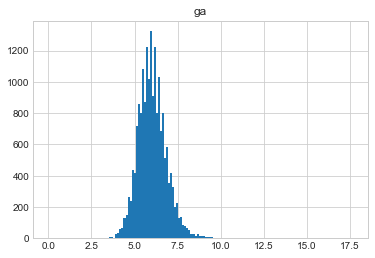

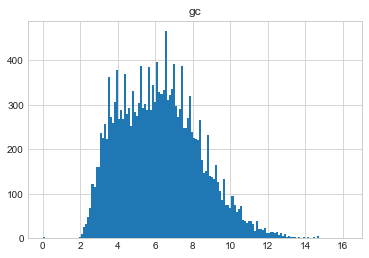

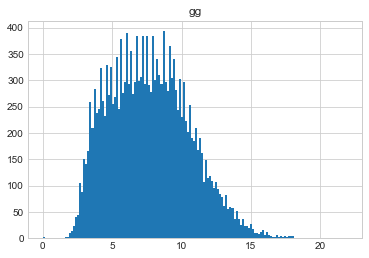

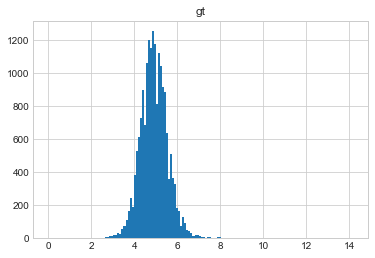

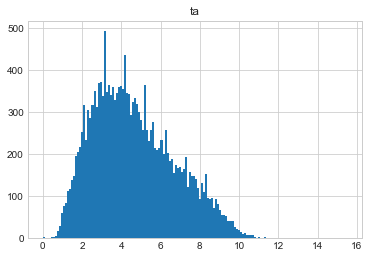

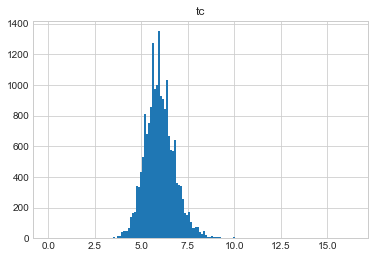

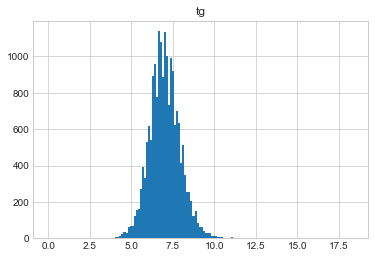

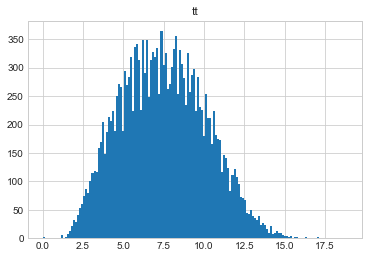

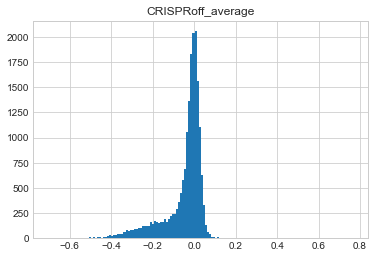

In [249]:
for i in cp.columns:
    plt.hist(cp[i], bins = 150)
    plt.title(i)
    plt.show()

In [163]:
pd.DataFrame(np.array([r]), columns = [cp.columns[:16]])

,aa,ac,ag,at,ca,cc,cg,ct,ga,gc,gg,gt,ta,tc,tg,tt
0,0.00002,0.000188,2.655148e-07,0.000055,0.000201,0.000041,0.000105,0.000008,0.00003,0.000065,0.000087,0.000011,0.000011,0.00001,0.00014,0.000002


In [184]:
matrix = pd.DataFrame()

for index, i in enumerate(kmers_2[:]):
    #print(i)

    if index == 0:
        temp1 = Properties[i.upper()]
        temp2 = DNA_features[i]

        matrix = pd.DataFrame(np.outer(temp2, temp1))

    else:

        temp1 = Properties[i.upper()]
        temp2 = DNA_features[i]
        temp_matrix = pd.DataFrame(np.outer(temp2, temp1))
        
        matrix = pd.concat([matrix, temp_matrix], axis = 1)


In [175]:
labels_x = []

for x, i in enumerate(Properties['Physicochemical properties']): #AA, AC, AT
    for o,n in enumerate(cp.columns): ### AA, AC, AT
            labels_x.append(str(i + '_' + n))

In [185]:
matrix.columns = labels_x

In [186]:
matrix = pd.concat([matrix, DNA_features], axis = 1)
matrix

,Base stacking_aa,Base stacking_ac,Base stacking_ag,Base stacking_at,Base stacking_ca,Base stacking_cc,Base stacking_cg,Base stacking_ct,Base stacking_ga,Base stacking_gc,...,cg,ct,ga,gc,gg,gt,ta,tc,tg,tt
0,7.548,-4.736,0.0,-10.138,7.326,-13.986,6.142,-0.888,-6.216,-6.66,...,3.733333,6.566667,7.266667,7.766667,9.933333,4.1,2.766667,5.133333,6.366667,3.4
1,8.908,-5.589333,0.0,-11.964667,8.646,-16.506,7.248667,-1.048,-7.336,-7.86,...,0.533333,8.166667,4.5,3.933333,3.566667,4.8,6.833333,7.566667,7.266667,11.066667
2,9.52,-5.973333,0.0,-12.786667,9.24,-17.64,7.746667,-1.12,-7.84,-8.4,...,0.766667,7.866667,6.0,3.766667,4.3,5.0,6.266667,7.066667,7.4,9.933333
3,8.772,-5.504,0.0,-11.782,8.514,-16.254,7.138,-1.032,-7.224,-7.74,...,1.4,8.7,6.0,4.6,6.433333,5.466667,5.366667,6.3,7.666667,8.566667
4,4.556,-2.858667,0.0,-6.119333,4.422,-8.442,3.707333,-0.536,-3.752,-4.02,...,5.2,7.466667,4.233333,8.1,6.433333,4.4,3.9,6.6,5.166667,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18745,6.63,-4.16,0.0,-8.905,6.435,-12.285,5.395,-0.78,-5.46,-5.85,...,5.833333,6.433333,5.4,7.833333,8.966667,6.233333,4.0,5.833333,7.333333,8.166667
18746,7.548,-4.736,0.0,-10.138,7.326,-13.986,6.142,-0.888,-6.216,-6.66,...,3.3,7.166667,7.4,5.966667,7.766667,5.266667,4.2,6.266667,6.933333,9.666667
18747,3.638,-2.282667,0.0,-4.886333,3.531,-6.741,2.960333,-0.428,-2.996,-3.21,...,6.766667,7.233333,6.766667,8.633333,14.066667,4.466667,1.733333,6.533333,5.7,3.433333
18748,7.548,-4.736,0.0,-10.138,7.326,-13.986,6.142,-0.888,-6.216,-6.66,...,2.166667,8.6,5.566667,5.466667,5.2,4.666667,4.933333,7.0,6.6,8.166667


In [187]:
#DNA_array = np.array(DNA_features.astype('int'))
DNA_array = np.array(matrix)

feature_list = list(matrix.columns)

In [188]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(DNA_array, df.CRISPRoff_average, test_size = 0.25, random_state = 42)

In [189]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('at')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.56


In [190]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor( random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [191]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.07 degrees.


In [192]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: -20.64 %.


In [120]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [121]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [307]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 7)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Aida_BA_transition_cg Importance: 0.0041524
Variable: Breslauer_dG_at      Importance: 0.0041472
Variable: Helix-Coil_transition_aa Importance: 0.0037084
Variable: Helix-Coil_transition_gg Importance: 0.003682
Variable: Aida_BA_transition_ca Importance: 0.0036498
Variable: Helix-Coil_transition_cg Importance: 0.0036402
Variable: Ivanov_BA_transition_ca Importance: 0.0036356
Variable: Breslauer_dG_gc      Importance: 0.003572
Variable: Ivanov_BA_transition_ac Importance: 0.0035349
Variable: Helix-Coil_transition_ac Importance: 0.0033694
Variable: Aida_BA_transition_ag Importance: 0.0033275
Variable: A-philicity_ga       Importance: 0.003285
Variable: Propeller twist_ca   Importance: 0.0032652
Variable: Aida_BA_transition_gt Importance: 0.0032331
Variable: ag                   Importance: 0.0032268
Variable: Aida_BA_transition_aa Importance: 0.0032135
Variable: Dinucleotide GC Content_gc Importance: 0.003212
Variable: A-philicity_aa       Importance: 0.0031806
Variable: A-phili

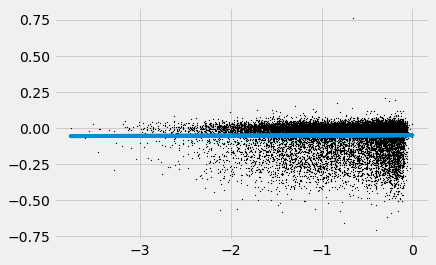

In [308]:
i = 'Breslauer_dG_at'

regression_data = matrix[['CRISPRoff_average',i]].dropna()

x =  np.array(regression_data[i].astype('float32')).reshape((-1,1))
y =  np.array(regression_data.CRISPRoff_average)

model = LinearRegression()

model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data[i].astype('float32')),y,1)

plt.scatter(x=matrix[i], y=matrix.CRISPRoff_average, c = 'black', s = 0.6)
plt.plot(x, m*x + b)


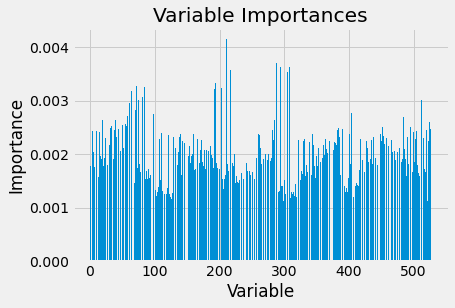

In [309]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
#plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

2.0366887906297926e-05
2.036695327256588e-05
2.03671878856726e-05
2.03669336975576e-05
2.03669299799758e-05
2.0366905149282744e-05
2.0366933784043972e-05
2.0367230287754445e-05
2.0366890763789947e-05
2.0366849961761524e-05
2.0366887906297926e-05
2.036697411134103e-05
2.0366933784043972e-05
2.036702306607019e-05
2.0366896317569605e-05
2.03671878856726e-05
2.036688215734106e-05
2.0366909049274184e-05
2.03669336975576e-05
Protein induced deformability_at


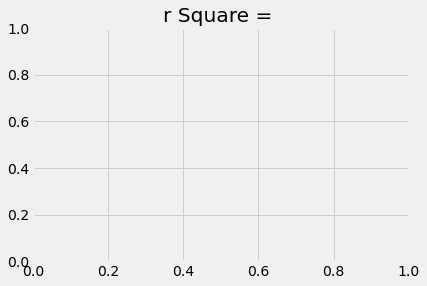

In [351]:
from sklearn.linear_model import LinearRegression

cycles = 0
r = 0
best = 'lol'
r_sq = 0

for i in matrix.columns[:20]:
    try:
        if sum(matrix[i]) == 0:
            #print(i)
            continue

        regression_data = matrix[['CRISPRoff_average',i]].dropna()

        x =  np.array(regression_data[i].astype('float32')).reshape((-1,1))
        y =  np.array(regression_data.CRISPRoff_average)

        model = LinearRegression()

        model.fit(x,y)
        model = LinearRegression().fit(x,y)
        r_sq = model.score(x, y)

        m,b = np.polyfit(np.array(regression_data[i].astype('float32')),y,1)

        cycles += 1
        print(r_sq)

        if r_sq > 0:
            r = r_sq
            best = str(i)

            plt.title('r Square = ', r_sq, size = 15)
            plt.xlabel('CRISPROff Phenotype')
            plt.ylabel(i)
            plt.scatter(x=matrix[i], y=matrix.CRISPRoff_average, c = 'black', s = 0.6)
            plt.plot(x, m*x + b)
            plt.show()
        else:
            r = r
        
    except:
        continue
        #print('problem with', i )
       # print(len(x), len(y))

print(best)

In [197]:
matrix['CRISPRoff_average'] = df['CRISPRoff_average']

In [232]:
matrix = matrix.round(4)

In [315]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

2.03669336975576e-05


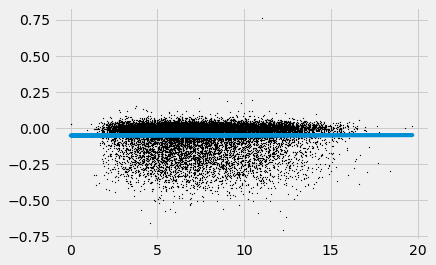

In [352]:
i = 'Protein induced deformability_at'

regression_data = matrix[['CRISPRoff_average',i]].dropna()

x =  np.array(regression_data[i].astype('float32')).reshape((-1,1))
y =  np.array(regression_data.CRISPRoff_average)

model = LinearRegression()

model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data[i].astype('float32')),y,1)

print(r_sq)

plt.scatter(x=matrix[i], y=matrix.CRISPRoff_average, c = 'black', s = 0.6)
plt.plot(x, m*x + b)


In [339]:
%history

import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests
Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)
Data = Data.sort_values(["gene",'average phenotype of strongest 3'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
UCSC_TSS = pd.read_csv('UCSC_TSS.txt', delimiter = '\t',header = 0)
UCSC_TSS = UCSC_TSS.drop_duplicates() 

errors = []

for gene in (Data['gene']):
        try:
                if len(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"]) > 1:
                        x = abs(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"] - Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1]).min()
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = (int(Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1] - int(x) + 1))
               

### KMERS 3

In [128]:
kmer_length = 3

def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [129]:
kmers_3 = np.unique(getKmers(df.Sequences[1], 3))

In [130]:
DNA_features = pd.DataFrame(index = range(len(df.Sequences)), columns = kmers_3)

In [132]:
for i, o in enumerate(df.Sequences[:]):
    for x in kmers_3:
        DNA_features[x][i] = Count_kmer(o, [x], 3)


In [133]:
DNA_array = np.array(DNA_features.astype('int'))
DNA_array = np.array(DNA_features)

feature_list = list(DNA_features.columns)

Mean Absolute Error: 0.07 degrees.
Accuracy: 25.89 %.
Variable: aaa                  Importance: 0.02
Variable: aac                  Importance: 0.02
Variable: aag                  Importance: 0.02
Variable: aca                  Importance: 0.02
Variable: acg                  Importance: 0.02
Variable: act                  Importance: 0.02
Variable: aga                  Importance: 0.02
Variable: agt                  Importance: 0.02
Variable: atc                  Importance: 0.02
Variable: atg                  Importance: 0.02
Variable: caa                  Importance: 0.02
Variable: cac                  Importance: 0.02
Variable: cat                  Importance: 0.02
Variable: ccc                  Importance: 0.02
Variable: cga                  Importance: 0.02
Variable: cgt                  Importance: 0.02
Variable: cta                  Importance: 0.02
Variable: ctc                  Importance: 0.02
Variable: ctt                  Importance: 0.02
Variable: gaa                  Imp

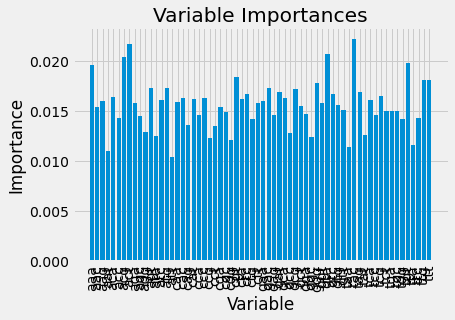

In [134]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(DNA_array, df.CRISPRoff_average, test_size = 0.25, random_state = 42)

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor( random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

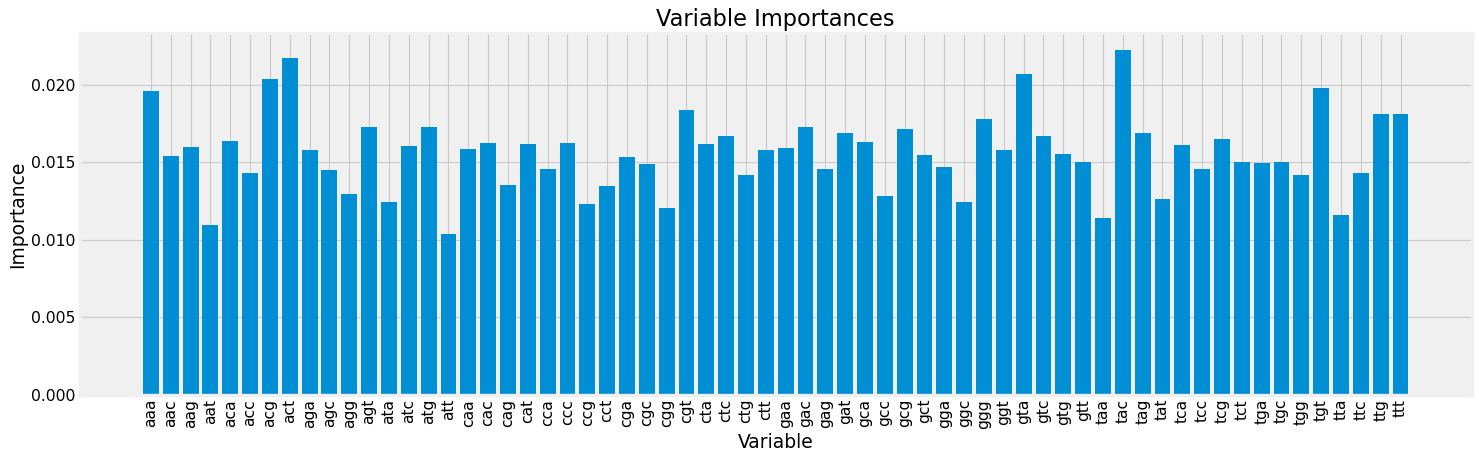

In [140]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
# Set the style

figure(figsize=(20, 6), dpi=80)
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [159]:
DNA_features.columns.values[:2]

array(['aaa', 'aac'], dtype=object)

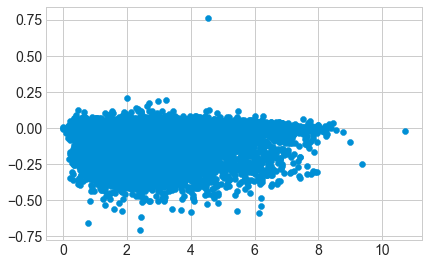

In [166]:
plt.scatter(x=DNA_features.aaa, y=df.CRISPRoff_average)

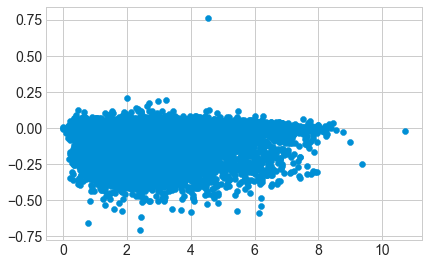

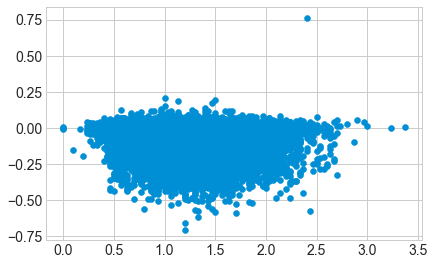

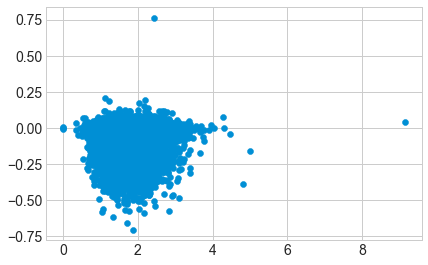

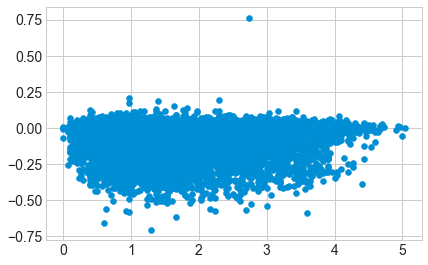

In [211]:
for col in DNA_features.columns.values[:4]:
    plt.scatter(x=DNA_features[col], y=df.CRISPRoff_average)
    plt.show()

In [186]:
DNA_features['pheontype'] = df.CRISPRoff_average

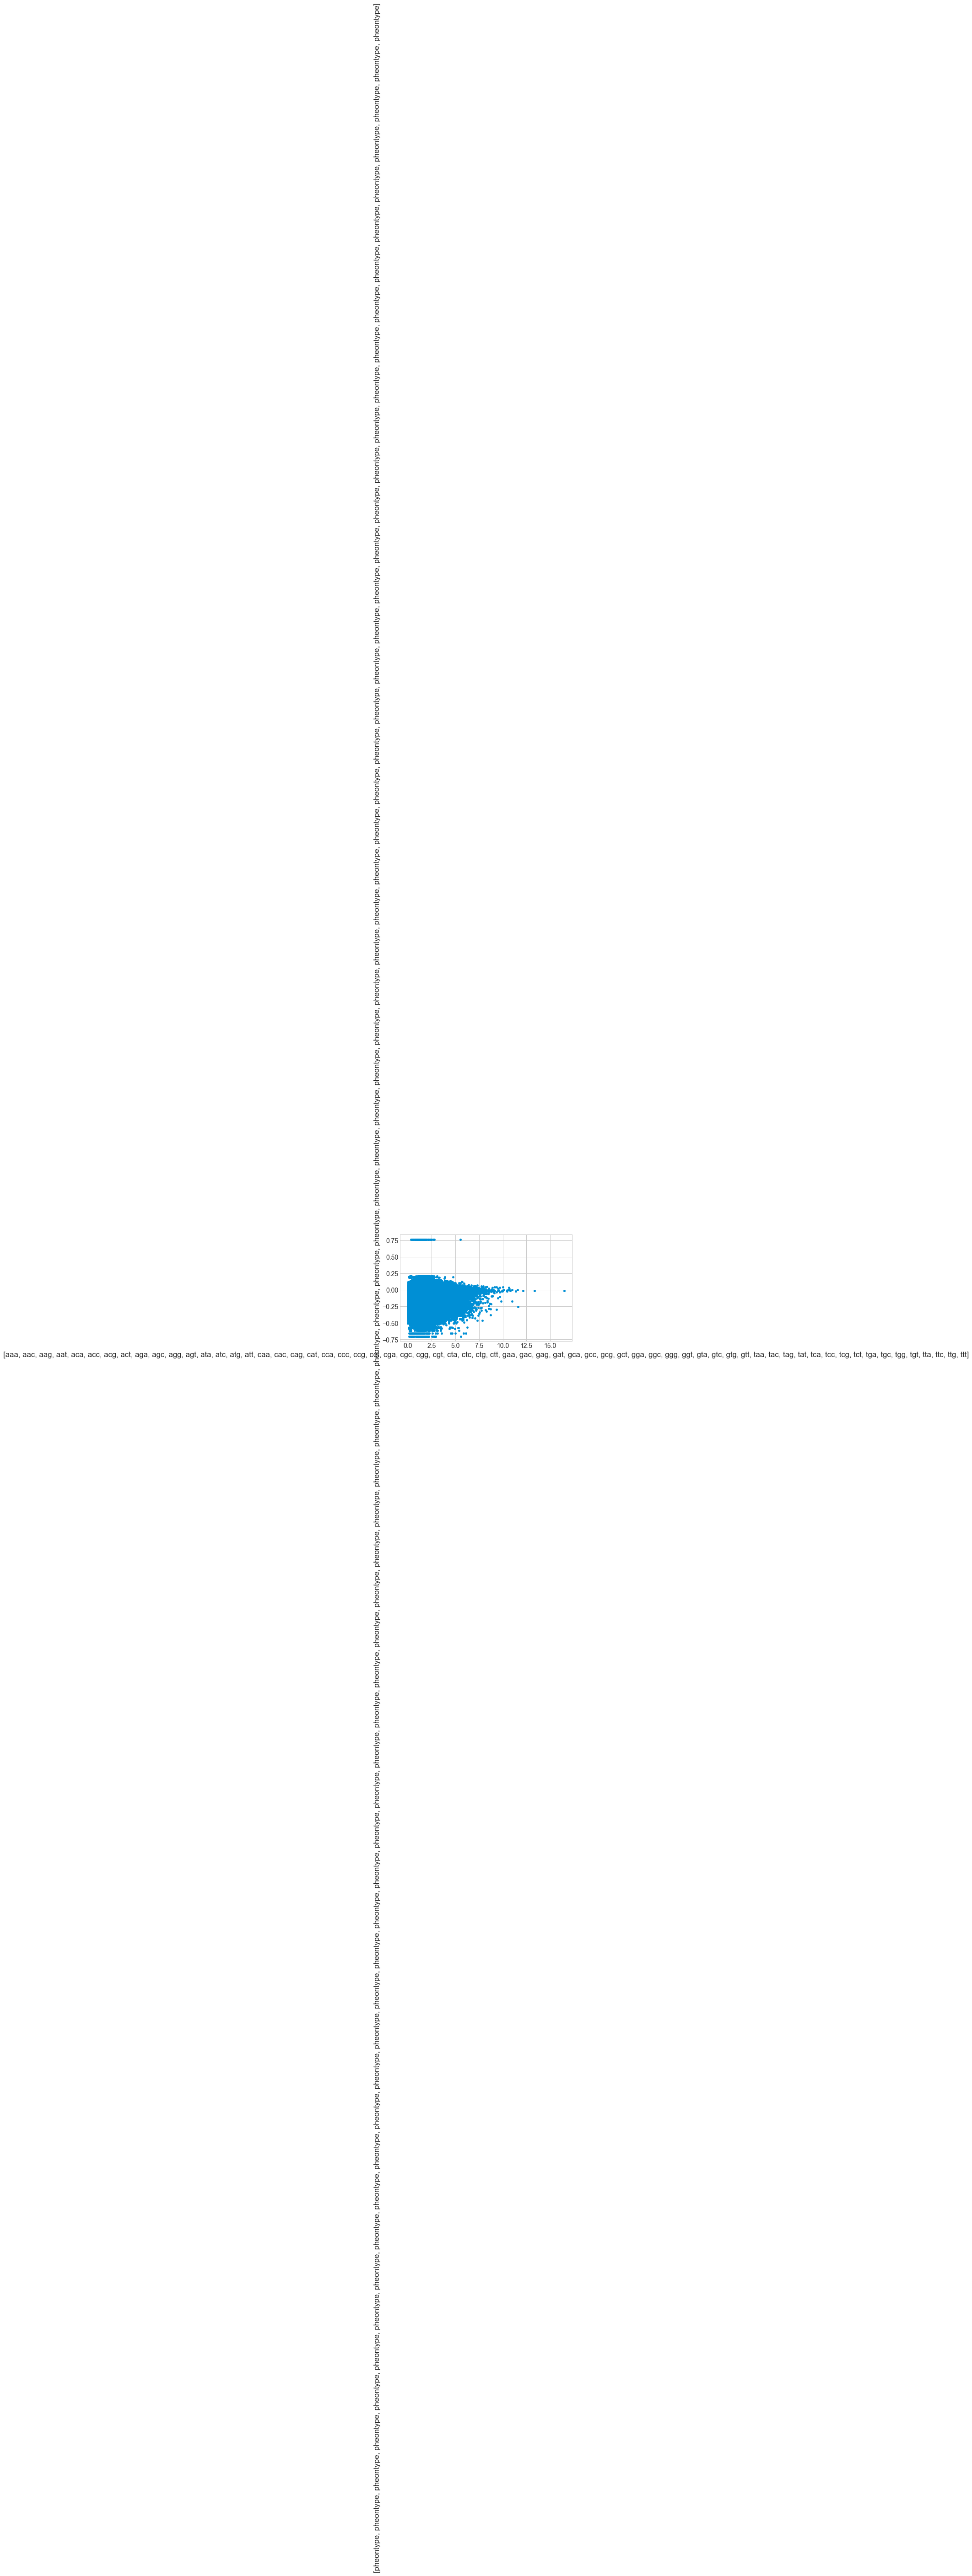

In [193]:
DNA_features.plot(x=DNA_features.columns.values[:-1], y=["pheontype" for _ in DNA_features.columns.values[:-1]], 
                            kind="scatter", subplots=True, sharey=False)
plt.show()